In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
pp.get_feature_list()

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat',
 'zip']

In [8]:
# records of 5 year
use_features = pp.get_feature_list()
df_track = pp.dataset(feature='delivered', valid=True, date=('2014-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(100599, 15)

In [9]:
# sanity check
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm = ModelManager(df_track[-9291:], ['date']+use_features, rf, time_series=True)
mm.split(test_size=3097, valid_size=3097)

[dp] track/sliding/test window size: 6194, 3097, 3097
[dp] train/valid/test size: 3097, 3097, 3097


In [10]:
# check ModelManager::split does the right order for time-series
print(mm.X_train[:3]['date'])
print(mm.X_train[-3:]['date'])
print(mm.X_val[:3]['date'])
print(mm.X_val[-3:]['date'])
print(mm.X_test[:3]['date'])
print(mm.X_test[-3:]['date'])

            date       date
99965 2017-06-28 2017-06-28
33817 2017-06-28 2017-06-28
25582 2017-06-28 2017-06-28
            date       date
96763 2017-07-27 2017-07-27
96762 2017-07-27 2017-07-27
96761 2017-07-27 2017-07-27
            date       date
1823  2017-07-27 2017-07-27
1822  2017-07-27 2017-07-27
16524 2017-07-27 2017-07-27
            date       date
61528 2017-08-25 2017-08-25
14910 2017-08-25 2017-08-25
19454 2017-08-25 2017-08-25
             date       date
19456  2017-08-25 2017-08-25
84371  2017-08-25 2017-08-25
105327 2017-08-25 2017-08-25
            date       date
28956 2017-09-27 2017-09-27
38502 2017-09-27 2017-09-27
60470 2017-09-27 2017-09-27


### Try RandomForest with different training and testing length
* 5 years(60 months) data is used in total for this validation
* testing length: 1, 2, ..., 6 months
* training: 1, 2, ..., up to 20x of testing length

In [11]:
# total dataset is 3 years = 36 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
df_track = pp.dataset(feature='delivered', valid=True, date=('2014-09-01', '2017-09-01'))

total = df_track.shape[0]
total_months = 36
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon
[dp] track/sliding/test window size: 5602, 2801, 2801
[dp] train/valid/test size: 2801, 2801, 2801
[dp] validation step is skipped


use 1 months training, 1 months testing, total dataset length:8403


[dp] track/sliding/test window size: 8403, 5602, 2801
[dp] train/valid/test size: 5602, 2801, 2801
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:11204


[dp] track/sliding/test window size: 11204, 8403, 2801
[dp] train/valid/test size: 8403, 2801, 2801
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:14005


[dp] track/sliding/test window size: 14005, 11204, 2801
[dp] train/valid/test size: 11204, 2801, 2801
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:16806


[dp] track/sliding/test window size: 16806, 14005, 2801
[dp] train/valid/test size: 14005, 2801, 2801
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:19607


[dp] track/sliding/test window size: 19607, 16806, 2801
[dp] train/valid/test size: 16806, 2801, 2801
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:22408


[dp] track/sliding/test window size: 22408, 19607, 2801
[dp] train/valid/test size: 19607, 2801, 2801
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:25209


[dp] track/sliding/test window size: 25209, 22408, 2801
[dp] train/valid/test size: 22408, 2801, 2801
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:28010


[dp] track/sliding/test window size: 28010, 25209, 2801
[dp] train/valid/test size: 25209, 2801, 2801
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:30811


[dp] track/sliding/test window size: 30811, 28010, 2801
[dp] train/valid/test size: 28010, 2801, 2801
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:33612


[dp] track/sliding/test window size: 33612, 30811, 2801
[dp] train/valid/test size: 30811, 2801, 2801
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:36413


[dp] track/sliding/test window size: 36413, 33612, 2801
[dp] train/valid/test size: 33612, 2801, 2801
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:39214


[dp] track/sliding/test window size: 39214, 36413, 2801
[dp] train/valid/test size: 36413, 2801, 2801
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:42015


[dp] track/sliding/test window size: 42015, 39214, 2801
[dp] train/valid/test size: 39214, 2801, 2801
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:44816


[dp] track/sliding/test window size: 44816, 42015, 2801
[dp] train/valid/test size: 42015, 2801, 2801
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:47617


[dp] track/sliding/test window size: 47617, 44816, 2801
[dp] train/valid/test size: 44816, 2801, 2801
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:50418


[dp] track/sliding/test window size: 50418, 47617, 2801
[dp] train/valid/test size: 47617, 2801, 2801
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:53219


[dp] track/sliding/test window size: 53219, 50418, 2801
[dp] train/valid/test size: 50418, 2801, 2801
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:56020


[dp] track/sliding/test window size: 56020, 53219, 2801
[dp] train/valid/test size: 53219, 2801, 2801
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:58821


[dp] track/sliding/test window size: 58821, 56020, 2801
[dp] train/valid/test size: 56020, 2801, 2801
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:61622


[dp] track/sliding/test window size: 61622, 58821, 2801
[dp] train/valid/test size: 58821, 2801, 2801
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:64423


[dp] track/sliding/test window size: 64423, 61622, 2801
[dp] train/valid/test size: 61622, 2801, 2801
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:67224


[dp] track/sliding/test window size: 67224, 64423, 2801
[dp] train/valid/test size: 64423, 2801, 2801
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:70025


[dp] track/sliding/test window size: 70025, 67224, 2801
[dp] train/valid/test size: 67224, 2801, 2801
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:72826


[dp] track/sliding/test window size: 72826, 70025, 2801
[dp] train/valid/test size: 70025, 2801, 2801
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:75627


[dp] track/sliding/test window size: 75627, 72826, 2801
[dp] train/valid/test size: 72826, 2801, 2801
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:78428


[dp] track/sliding/test window size: 78428, 75627, 2801
[dp] train/valid/test size: 75627, 2801, 2801
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:81229


[dp] track/sliding/test window size: 81229, 78428, 2801
[dp] train/valid/test size: 78428, 2801, 2801
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:84030


[dp] track/sliding/test window size: 84030, 81229, 2801
[dp] train/valid/test size: 81229, 2801, 2801
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:86831


[dp] track/sliding/test window size: 86831, 84030, 2801
[dp] train/valid/test size: 84030, 2801, 2801
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:89632


[dp] track/sliding/test window size: 89632, 86831, 2801
[dp] train/valid/test size: 86831, 2801, 2801
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:92433


[dp] track/sliding/test window size: 92433, 89632, 2801
[dp] train/valid/test size: 89632, 2801, 2801
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:95234


[dp] track/sliding/test window size: 95234, 92433, 2801
[dp] train/valid/test size: 92433, 2801, 2801
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:98035


[dp] track/sliding/test window size: 98035, 95234, 2801
[dp] train/valid/test size: 95234, 2801, 2801
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:100836


[dp] track/sliding/test window size: 98045, 95244, 2801
[dp] train/valid/test size: 95244, 2801, 2801
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:100846


[dp] track/sliding/test window size: 11204, 5602, 5602
[dp] train/valid/test size: 5602, 5602, 5602
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:16806


[dp] track/sliding/test window size: 16806, 11204, 5602
[dp] train/valid/test size: 11204, 5602, 5602
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:22408


[dp] track/sliding/test window size: 22408, 16806, 5602
[dp] train/valid/test size: 16806, 5602, 5602
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:28010


[dp] track/sliding/test window size: 28010, 22408, 5602
[dp] train/valid/test size: 22408, 5602, 5602
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:33612


[dp] track/sliding/test window size: 33612, 28010, 5602
[dp] train/valid/test size: 28010, 5602, 5602
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:39214


[dp] track/sliding/test window size: 39214, 33612, 5602
[dp] train/valid/test size: 33612, 5602, 5602
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:44816


[dp] track/sliding/test window size: 44816, 39214, 5602
[dp] train/valid/test size: 39214, 5602, 5602
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:50418


[dp] track/sliding/test window size: 50418, 44816, 5602
[dp] train/valid/test size: 44816, 5602, 5602
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:56020


[dp] track/sliding/test window size: 56020, 50418, 5602
[dp] train/valid/test size: 50418, 5602, 5602
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:61622


[dp] track/sliding/test window size: 61622, 56020, 5602
[dp] train/valid/test size: 56020, 5602, 5602
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:67224


[dp] track/sliding/test window size: 67224, 61622, 5602
[dp] train/valid/test size: 61622, 5602, 5602
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:72826


[dp] track/sliding/test window size: 72826, 67224, 5602
[dp] train/valid/test size: 67224, 5602, 5602
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:78428


[dp] track/sliding/test window size: 78428, 72826, 5602
[dp] train/valid/test size: 72826, 5602, 5602
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:84030


[dp] track/sliding/test window size: 84030, 78428, 5602
[dp] train/valid/test size: 78428, 5602, 5602
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:89632


[dp] track/sliding/test window size: 89632, 84030, 5602
[dp] train/valid/test size: 84030, 5602, 5602
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:95234


[dp] track/sliding/test window size: 95234, 89632, 5602
[dp] train/valid/test size: 89632, 5602, 5602
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:100836


[dp] track/sliding/test window size: 95244, 89642, 5602
[dp] train/valid/test size: 89642, 5602, 5602
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:100846


[dp] track/sliding/test window size: 16806, 8403, 8403
[dp] train/valid/test size: 8403, 8403, 8403
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:25209


[dp] track/sliding/test window size: 25209, 16806, 8403
[dp] train/valid/test size: 16806, 8403, 8403
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:33612


[dp] track/sliding/test window size: 33612, 25209, 8403
[dp] train/valid/test size: 25209, 8403, 8403
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:42015


[dp] track/sliding/test window size: 42015, 33612, 8403
[dp] train/valid/test size: 33612, 8403, 8403
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:50418


[dp] track/sliding/test window size: 50418, 42015, 8403
[dp] train/valid/test size: 42015, 8403, 8403
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:58821


[dp] track/sliding/test window size: 58821, 50418, 8403
[dp] train/valid/test size: 50418, 8403, 8403
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:67224


[dp] track/sliding/test window size: 67224, 58821, 8403
[dp] train/valid/test size: 58821, 8403, 8403
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:75627


[dp] track/sliding/test window size: 75627, 67224, 8403
[dp] train/valid/test size: 67224, 8403, 8403
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:84030


[dp] track/sliding/test window size: 84030, 75627, 8403
[dp] train/valid/test size: 75627, 8403, 8403
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:92433


[dp] track/sliding/test window size: 92433, 84030, 8403
[dp] train/valid/test size: 84030, 8403, 8403
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:100836


[dp] track/sliding/test window size: 92443, 84040, 8403
[dp] train/valid/test size: 84040, 8403, 8403
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:100846


[dp] track/sliding/test window size: 22410, 11205, 11205
[dp] train/valid/test size: 11205, 11205, 11205
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:33615


[dp] track/sliding/test window size: 33615, 22410, 11205
[dp] train/valid/test size: 22410, 11205, 11205
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:44820


[dp] track/sliding/test window size: 44820, 33615, 11205
[dp] train/valid/test size: 33615, 11205, 11205
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:56025


[dp] track/sliding/test window size: 56025, 44820, 11205
[dp] train/valid/test size: 44820, 11205, 11205
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:67230


[dp] track/sliding/test window size: 67230, 56025, 11205
[dp] train/valid/test size: 56025, 11205, 11205
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:78435


[dp] track/sliding/test window size: 78435, 67230, 11205
[dp] train/valid/test size: 67230, 11205, 11205
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:89640


[dp] track/sliding/test window size: 89640, 78435, 11205
[dp] train/valid/test size: 78435, 11205, 11205
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:100845


[dp] track/sliding/test window size: 89641, 78436, 11205
[dp] train/valid/test size: 78436, 11205, 11205
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:100846


[dp] track/sliding/test window size: 28812, 14406, 14406
[dp] train/valid/test size: 14406, 14406, 14406
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:43218


[dp] track/sliding/test window size: 43218, 28812, 14406
[dp] train/valid/test size: 28812, 14406, 14406
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:57624


[dp] track/sliding/test window size: 57624, 43218, 14406
[dp] train/valid/test size: 43218, 14406, 14406
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:72030


[dp] track/sliding/test window size: 72030, 57624, 14406
[dp] train/valid/test size: 57624, 14406, 14406
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:86436


[dp] track/sliding/test window size: 86436, 72030, 14406
[dp] train/valid/test size: 72030, 14406, 14406
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:100842


[dp] track/sliding/test window size: 86440, 72034, 14406
[dp] train/valid/test size: 72034, 14406, 14406
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:100846


[dp] track/sliding/test window size: 33614, 16807, 16807
[dp] train/valid/test size: 16807, 16807, 16807
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:50421


[dp] track/sliding/test window size: 50421, 33614, 16807
[dp] train/valid/test size: 33614, 16807, 16807
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:67228


[dp] track/sliding/test window size: 67228, 50421, 16807
[dp] train/valid/test size: 50421, 16807, 16807
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:84035


[dp] track/sliding/test window size: 84035, 67228, 16807
[dp] train/valid/test size: 67228, 16807, 16807
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:100842


[dp] track/sliding/test window size: 84039, 67232, 16807
[dp] train/valid/test size: 67232, 16807, 16807
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:100846


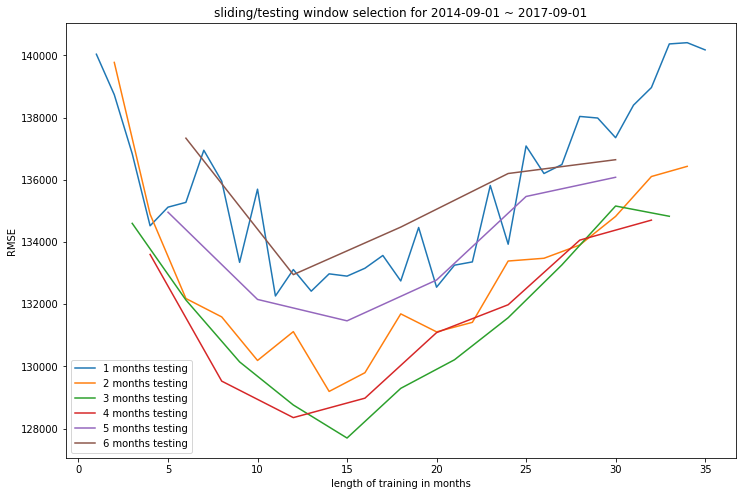

In [13]:
fig=plt.figure(figsize=(12,8))
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months testing'.format(j))

plt.title('sliding/testing window selection for 2014-09-01 ~ 2017-09-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [45]:
### debug why 1month test has that poor performance
### pick the point of 15-month training to compare between 1month testing and 4months testing
df_debug = pp.dataset(feature='delivered', valid=True, date=('2014-10-01', '2017-10-01'))

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


In [38]:
total = df_debug.shape[0]
j = 1
total_months = 36
montly = int(total / total_months)

use_length = monthly*17
df_train_test = df_debug[-use_length:]
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm = ModelManager(df_train_test, use_features, rf, time_series=True)
score = mm.run(test_size=length_segment, valid_size=length_segment)
score

[dp] track/sliding/test window size: 44704, 41910, 2794
[dp] train/valid/test size: 41910, 2794, 2794
[dp] validation step is skipped


145590.6454696371

In [27]:
length_segment = monthly*4
use_length = length_segment*6
df_train_test = df_debug[-use_length:]

rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm1 = ModelManager(df_train_test, use_features, rf, time_series=True)
score = mm1.run(test_size=length_segment, valid_size=length_segment)

[dp] track/sliding/test window size: 55890, 44712, 11178
[dp] train/valid/test size: 44712, 11178, 11178
[dp] validation step is skipped


In [42]:
df_result = mm1.get_result_df()
df_last = df_result[-monthly:]
sqrt(mean_squared_error(df_last['predict'], df_last['sold_price']))

148460.50513762012

In [41]:
# now we can see, the 4 months testing doesn't perform better than 1month on predicting the last month
# so the poor performance of 1month-testing is due to high variance in data, probably due to outliers in last month
# suggest we need go back to do more cleaning on data

148460.50513762012

### conclusion
* testing size of 1 or 2 months is a little too small and model performance is not very stable
* testing size of >= 3 looks similar
* training length has elbow point at around 10~15 months
* let's try testing length: 4, training: 12

In [14]:
### redo for 2003~2008
df_track1 = pp.dataset(feature='delivered', valid=True, date=('2003-01-01', '2006-01-01'))
print(df_track1.shape)

# total dataset is 3 years = 36 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track1.shape[0]
total_months = 36
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track1[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon
[dp] track/sliding/test window size: 9340, 4670, 4670
[dp] train/valid/test size: 4670, 4670, 4670
[dp] validation step is skipped


(168153, 15)
use 1 months training, 1 months testing, total dataset length:14010


[dp] track/sliding/test window size: 14010, 9340, 4670
[dp] train/valid/test size: 9340, 4670, 4670
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:18680


[dp] track/sliding/test window size: 18680, 14010, 4670
[dp] train/valid/test size: 14010, 4670, 4670
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:23350


[dp] track/sliding/test window size: 23350, 18680, 4670
[dp] train/valid/test size: 18680, 4670, 4670
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:28020


[dp] track/sliding/test window size: 28020, 23350, 4670
[dp] train/valid/test size: 23350, 4670, 4670
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:32690


[dp] track/sliding/test window size: 32690, 28020, 4670
[dp] train/valid/test size: 28020, 4670, 4670
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:37360


[dp] track/sliding/test window size: 37360, 32690, 4670
[dp] train/valid/test size: 32690, 4670, 4670
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:42030


[dp] track/sliding/test window size: 42030, 37360, 4670
[dp] train/valid/test size: 37360, 4670, 4670
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:46700


[dp] track/sliding/test window size: 46700, 42030, 4670
[dp] train/valid/test size: 42030, 4670, 4670
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:51370


[dp] track/sliding/test window size: 51370, 46700, 4670
[dp] train/valid/test size: 46700, 4670, 4670
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:56040


[dp] track/sliding/test window size: 56040, 51370, 4670
[dp] train/valid/test size: 51370, 4670, 4670
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:60710


[dp] track/sliding/test window size: 60710, 56040, 4670
[dp] train/valid/test size: 56040, 4670, 4670
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:65380


[dp] track/sliding/test window size: 65380, 60710, 4670
[dp] train/valid/test size: 60710, 4670, 4670
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:70050


[dp] track/sliding/test window size: 70050, 65380, 4670
[dp] train/valid/test size: 65380, 4670, 4670
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:74720


[dp] track/sliding/test window size: 74720, 70050, 4670
[dp] train/valid/test size: 70050, 4670, 4670
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:79390


[dp] track/sliding/test window size: 79390, 74720, 4670
[dp] train/valid/test size: 74720, 4670, 4670
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:84060


[dp] track/sliding/test window size: 84060, 79390, 4670
[dp] train/valid/test size: 79390, 4670, 4670
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:88730


[dp] track/sliding/test window size: 88730, 84060, 4670
[dp] train/valid/test size: 84060, 4670, 4670
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:93400


[dp] track/sliding/test window size: 93400, 88730, 4670
[dp] train/valid/test size: 88730, 4670, 4670
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:98070


[dp] track/sliding/test window size: 98070, 93400, 4670
[dp] train/valid/test size: 93400, 4670, 4670
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:102740


[dp] track/sliding/test window size: 102740, 98070, 4670
[dp] train/valid/test size: 98070, 4670, 4670
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:107410


[dp] track/sliding/test window size: 107410, 102740, 4670
[dp] train/valid/test size: 102740, 4670, 4670
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:112080


[dp] track/sliding/test window size: 112080, 107410, 4670
[dp] train/valid/test size: 107410, 4670, 4670
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:116750


[dp] track/sliding/test window size: 116750, 112080, 4670
[dp] train/valid/test size: 112080, 4670, 4670
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:121420


[dp] track/sliding/test window size: 121420, 116750, 4670
[dp] train/valid/test size: 116750, 4670, 4670
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:126090


[dp] track/sliding/test window size: 126090, 121420, 4670
[dp] train/valid/test size: 121420, 4670, 4670
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:130760


[dp] track/sliding/test window size: 130760, 126090, 4670
[dp] train/valid/test size: 126090, 4670, 4670
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:135430


[dp] track/sliding/test window size: 135430, 130760, 4670
[dp] train/valid/test size: 130760, 4670, 4670
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:140100


[dp] track/sliding/test window size: 140100, 135430, 4670
[dp] train/valid/test size: 135430, 4670, 4670
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:144770


[dp] track/sliding/test window size: 144770, 140100, 4670
[dp] train/valid/test size: 140100, 4670, 4670
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:149440


[dp] track/sliding/test window size: 149440, 144770, 4670
[dp] train/valid/test size: 144770, 4670, 4670
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:154110


[dp] track/sliding/test window size: 154110, 149440, 4670
[dp] train/valid/test size: 149440, 4670, 4670
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:158780


[dp] track/sliding/test window size: 158780, 154110, 4670
[dp] train/valid/test size: 154110, 4670, 4670
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:163450


[dp] track/sliding/test window size: 163450, 158780, 4670
[dp] train/valid/test size: 158780, 4670, 4670
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:168120


[dp] track/sliding/test window size: 163483, 158813, 4670
[dp] train/valid/test size: 158813, 4670, 4670
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:168153


[dp] track/sliding/test window size: 18682, 9341, 9341
[dp] train/valid/test size: 9341, 9341, 9341
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:28023


[dp] track/sliding/test window size: 28023, 18682, 9341
[dp] train/valid/test size: 18682, 9341, 9341
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:37364


[dp] track/sliding/test window size: 37364, 28023, 9341
[dp] train/valid/test size: 28023, 9341, 9341
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:46705


[dp] track/sliding/test window size: 46705, 37364, 9341
[dp] train/valid/test size: 37364, 9341, 9341
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:56046


[dp] track/sliding/test window size: 56046, 46705, 9341
[dp] train/valid/test size: 46705, 9341, 9341
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:65387


[dp] track/sliding/test window size: 65387, 56046, 9341
[dp] train/valid/test size: 56046, 9341, 9341
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:74728


[dp] track/sliding/test window size: 74728, 65387, 9341
[dp] train/valid/test size: 65387, 9341, 9341
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:84069


[dp] track/sliding/test window size: 84069, 74728, 9341
[dp] train/valid/test size: 74728, 9341, 9341
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:93410


[dp] track/sliding/test window size: 93410, 84069, 9341
[dp] train/valid/test size: 84069, 9341, 9341
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:102751


[dp] track/sliding/test window size: 102751, 93410, 9341
[dp] train/valid/test size: 93410, 9341, 9341
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:112092


[dp] track/sliding/test window size: 112092, 102751, 9341
[dp] train/valid/test size: 102751, 9341, 9341
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:121433


[dp] track/sliding/test window size: 121433, 112092, 9341
[dp] train/valid/test size: 112092, 9341, 9341
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:130774


[dp] track/sliding/test window size: 130774, 121433, 9341
[dp] train/valid/test size: 121433, 9341, 9341
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:140115


[dp] track/sliding/test window size: 140115, 130774, 9341
[dp] train/valid/test size: 130774, 9341, 9341
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:149456


[dp] track/sliding/test window size: 149456, 140115, 9341
[dp] train/valid/test size: 140115, 9341, 9341
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:158797


[dp] track/sliding/test window size: 158797, 149456, 9341
[dp] train/valid/test size: 149456, 9341, 9341
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:168138


[dp] track/sliding/test window size: 158812, 149471, 9341
[dp] train/valid/test size: 149471, 9341, 9341
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:168153


[dp] track/sliding/test window size: 28024, 14012, 14012
[dp] train/valid/test size: 14012, 14012, 14012
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:42036


[dp] track/sliding/test window size: 42036, 28024, 14012
[dp] train/valid/test size: 28024, 14012, 14012
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:56048


[dp] track/sliding/test window size: 56048, 42036, 14012
[dp] train/valid/test size: 42036, 14012, 14012
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:70060


[dp] track/sliding/test window size: 70060, 56048, 14012
[dp] train/valid/test size: 56048, 14012, 14012
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:84072


[dp] track/sliding/test window size: 84072, 70060, 14012
[dp] train/valid/test size: 70060, 14012, 14012
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:98084


[dp] track/sliding/test window size: 98084, 84072, 14012
[dp] train/valid/test size: 84072, 14012, 14012
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:112096


[dp] track/sliding/test window size: 112096, 98084, 14012
[dp] train/valid/test size: 98084, 14012, 14012
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:126108


[dp] track/sliding/test window size: 126108, 112096, 14012
[dp] train/valid/test size: 112096, 14012, 14012
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:140120


[dp] track/sliding/test window size: 140120, 126108, 14012
[dp] train/valid/test size: 126108, 14012, 14012
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:154132


[dp] track/sliding/test window size: 154132, 140120, 14012
[dp] train/valid/test size: 140120, 14012, 14012
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:168144


[dp] track/sliding/test window size: 154141, 140129, 14012
[dp] train/valid/test size: 140129, 14012, 14012
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:168153


[dp] track/sliding/test window size: 37366, 18683, 18683
[dp] train/valid/test size: 18683, 18683, 18683
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:56049


[dp] track/sliding/test window size: 56049, 37366, 18683
[dp] train/valid/test size: 37366, 18683, 18683
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:74732


[dp] track/sliding/test window size: 74732, 56049, 18683
[dp] train/valid/test size: 56049, 18683, 18683
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:93415


[dp] track/sliding/test window size: 93415, 74732, 18683
[dp] train/valid/test size: 74732, 18683, 18683
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:112098


[dp] track/sliding/test window size: 112098, 93415, 18683
[dp] train/valid/test size: 93415, 18683, 18683
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:130781


[dp] track/sliding/test window size: 130781, 112098, 18683
[dp] train/valid/test size: 112098, 18683, 18683
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:149464


[dp] track/sliding/test window size: 149464, 130781, 18683
[dp] train/valid/test size: 130781, 18683, 18683
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:168147


[dp] track/sliding/test window size: 149470, 130787, 18683
[dp] train/valid/test size: 130787, 18683, 18683
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:168153


[dp] track/sliding/test window size: 48042, 24021, 24021
[dp] train/valid/test size: 24021, 24021, 24021
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:72063


[dp] track/sliding/test window size: 72063, 48042, 24021
[dp] train/valid/test size: 48042, 24021, 24021
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:96084


[dp] track/sliding/test window size: 96084, 72063, 24021
[dp] train/valid/test size: 72063, 24021, 24021
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:120105


[dp] track/sliding/test window size: 120105, 96084, 24021
[dp] train/valid/test size: 96084, 24021, 24021
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:144126


[dp] track/sliding/test window size: 144126, 120105, 24021
[dp] train/valid/test size: 120105, 24021, 24021
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:168147


[dp] track/sliding/test window size: 144132, 120111, 24021
[dp] train/valid/test size: 120111, 24021, 24021
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:168153


[dp] track/sliding/test window size: 56050, 28025, 28025
[dp] train/valid/test size: 28025, 28025, 28025
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:84075


[dp] track/sliding/test window size: 84075, 56050, 28025
[dp] train/valid/test size: 56050, 28025, 28025
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:112100


[dp] track/sliding/test window size: 112100, 84075, 28025
[dp] train/valid/test size: 84075, 28025, 28025
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:140125


[dp] track/sliding/test window size: 140125, 112100, 28025
[dp] train/valid/test size: 112100, 28025, 28025
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:168150


[dp] track/sliding/test window size: 140128, 112103, 28025
[dp] train/valid/test size: 112103, 28025, 28025
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:168153


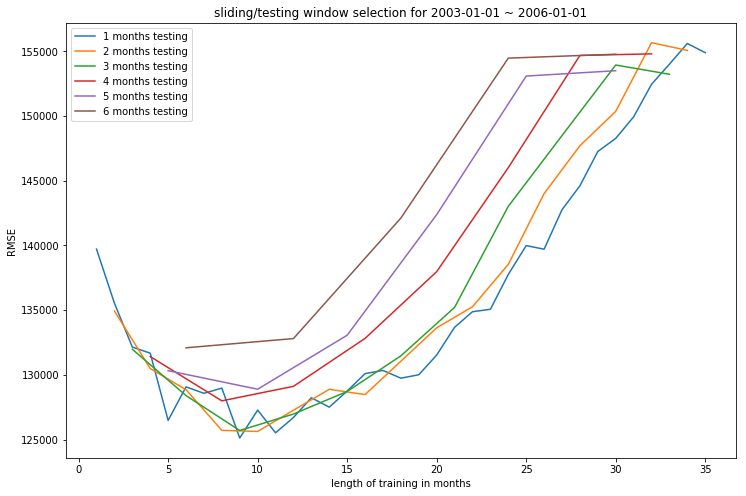

best training length for 2 months testing set is 10


In [16]:
fig=plt.figure(figsize=(12,8))
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months testing'.format(j))

plt.title('sliding/testing window selection for 2003-01-01 ~ 2006-01-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()

print('best training length for 2 months testing set is {}'.format((np.argmin(scores)+1)*2))

In [19]:
### redo for 2006~2009
df_track1 = pp.dataset(feature='delivered', valid=True, date=('2006-06-01', '2009-06-01'))
print(df_track1.shape)

# total dataset is 3 years = 36 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track1.shape[0]
total_months = 36
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track1[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon
[dp] track/sliding/test window size: 5246, 2623, 2623
[dp] train/valid/test size: 2623, 2623, 2623
[dp] validation step is skipped


(94452, 15)
use 1 months training, 1 months testing, total dataset length:7869


[dp] track/sliding/test window size: 7869, 5246, 2623
[dp] train/valid/test size: 5246, 2623, 2623
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:10492


[dp] track/sliding/test window size: 10492, 7869, 2623
[dp] train/valid/test size: 7869, 2623, 2623
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:13115


[dp] track/sliding/test window size: 13115, 10492, 2623
[dp] train/valid/test size: 10492, 2623, 2623
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:15738


[dp] track/sliding/test window size: 15738, 13115, 2623
[dp] train/valid/test size: 13115, 2623, 2623
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:18361


[dp] track/sliding/test window size: 18361, 15738, 2623
[dp] train/valid/test size: 15738, 2623, 2623
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:20984


[dp] track/sliding/test window size: 20984, 18361, 2623
[dp] train/valid/test size: 18361, 2623, 2623
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:23607


[dp] track/sliding/test window size: 23607, 20984, 2623
[dp] train/valid/test size: 20984, 2623, 2623
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:26230


[dp] track/sliding/test window size: 26230, 23607, 2623
[dp] train/valid/test size: 23607, 2623, 2623
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:28853


[dp] track/sliding/test window size: 28853, 26230, 2623
[dp] train/valid/test size: 26230, 2623, 2623
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:31476


[dp] track/sliding/test window size: 31476, 28853, 2623
[dp] train/valid/test size: 28853, 2623, 2623
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:34099


[dp] track/sliding/test window size: 34099, 31476, 2623
[dp] train/valid/test size: 31476, 2623, 2623
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:36722


[dp] track/sliding/test window size: 36722, 34099, 2623
[dp] train/valid/test size: 34099, 2623, 2623
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:39345


[dp] track/sliding/test window size: 39345, 36722, 2623
[dp] train/valid/test size: 36722, 2623, 2623
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:41968


[dp] track/sliding/test window size: 41968, 39345, 2623
[dp] train/valid/test size: 39345, 2623, 2623
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:44591


[dp] track/sliding/test window size: 44591, 41968, 2623
[dp] train/valid/test size: 41968, 2623, 2623
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:47214


[dp] track/sliding/test window size: 47214, 44591, 2623
[dp] train/valid/test size: 44591, 2623, 2623
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:49837


[dp] track/sliding/test window size: 49837, 47214, 2623
[dp] train/valid/test size: 47214, 2623, 2623
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:52460


[dp] track/sliding/test window size: 52460, 49837, 2623
[dp] train/valid/test size: 49837, 2623, 2623
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:55083


[dp] track/sliding/test window size: 55083, 52460, 2623
[dp] train/valid/test size: 52460, 2623, 2623
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:57706


[dp] track/sliding/test window size: 57706, 55083, 2623
[dp] train/valid/test size: 55083, 2623, 2623
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:60329


[dp] track/sliding/test window size: 60329, 57706, 2623
[dp] train/valid/test size: 57706, 2623, 2623
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:62952


[dp] track/sliding/test window size: 62952, 60329, 2623
[dp] train/valid/test size: 60329, 2623, 2623
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:65575


[dp] track/sliding/test window size: 65575, 62952, 2623
[dp] train/valid/test size: 62952, 2623, 2623
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:68198


[dp] track/sliding/test window size: 68198, 65575, 2623
[dp] train/valid/test size: 65575, 2623, 2623
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:70821


[dp] track/sliding/test window size: 70821, 68198, 2623
[dp] train/valid/test size: 68198, 2623, 2623
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:73444


[dp] track/sliding/test window size: 73444, 70821, 2623
[dp] train/valid/test size: 70821, 2623, 2623
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:76067


[dp] track/sliding/test window size: 76067, 73444, 2623
[dp] train/valid/test size: 73444, 2623, 2623
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:78690


[dp] track/sliding/test window size: 78690, 76067, 2623
[dp] train/valid/test size: 76067, 2623, 2623
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:81313


[dp] track/sliding/test window size: 81313, 78690, 2623
[dp] train/valid/test size: 78690, 2623, 2623
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:83936


[dp] track/sliding/test window size: 83936, 81313, 2623
[dp] train/valid/test size: 81313, 2623, 2623
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:86559


[dp] track/sliding/test window size: 86559, 83936, 2623
[dp] train/valid/test size: 83936, 2623, 2623
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:89182


[dp] track/sliding/test window size: 89182, 86559, 2623
[dp] train/valid/test size: 86559, 2623, 2623
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:91805


[dp] track/sliding/test window size: 91805, 89182, 2623
[dp] train/valid/test size: 89182, 2623, 2623
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:94428


[dp] track/sliding/test window size: 91829, 89206, 2623
[dp] train/valid/test size: 89206, 2623, 2623
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:94452


[dp] track/sliding/test window size: 10494, 5247, 5247
[dp] train/valid/test size: 5247, 5247, 5247
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:15741


[dp] track/sliding/test window size: 15741, 10494, 5247
[dp] train/valid/test size: 10494, 5247, 5247
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:20988


[dp] track/sliding/test window size: 20988, 15741, 5247
[dp] train/valid/test size: 15741, 5247, 5247
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:26235


[dp] track/sliding/test window size: 26235, 20988, 5247
[dp] train/valid/test size: 20988, 5247, 5247
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:31482


[dp] track/sliding/test window size: 31482, 26235, 5247
[dp] train/valid/test size: 26235, 5247, 5247
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:36729


[dp] track/sliding/test window size: 36729, 31482, 5247
[dp] train/valid/test size: 31482, 5247, 5247
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:41976


[dp] track/sliding/test window size: 41976, 36729, 5247
[dp] train/valid/test size: 36729, 5247, 5247
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:47223


[dp] track/sliding/test window size: 47223, 41976, 5247
[dp] train/valid/test size: 41976, 5247, 5247
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:52470


[dp] track/sliding/test window size: 52470, 47223, 5247
[dp] train/valid/test size: 47223, 5247, 5247
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:57717


[dp] track/sliding/test window size: 57717, 52470, 5247
[dp] train/valid/test size: 52470, 5247, 5247
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:62964


[dp] track/sliding/test window size: 62964, 57717, 5247
[dp] train/valid/test size: 57717, 5247, 5247
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:68211


[dp] track/sliding/test window size: 68211, 62964, 5247
[dp] train/valid/test size: 62964, 5247, 5247
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:73458


[dp] track/sliding/test window size: 73458, 68211, 5247
[dp] train/valid/test size: 68211, 5247, 5247
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:78705


[dp] track/sliding/test window size: 78705, 73458, 5247
[dp] train/valid/test size: 73458, 5247, 5247
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:83952


[dp] track/sliding/test window size: 83952, 78705, 5247
[dp] train/valid/test size: 78705, 5247, 5247
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:89199


[dp] track/sliding/test window size: 89199, 83952, 5247
[dp] train/valid/test size: 83952, 5247, 5247
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:94446


[dp] track/sliding/test window size: 89205, 83958, 5247
[dp] train/valid/test size: 83958, 5247, 5247
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:94452


[dp] track/sliding/test window size: 15742, 7871, 7871
[dp] train/valid/test size: 7871, 7871, 7871
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:23613


[dp] track/sliding/test window size: 23613, 15742, 7871
[dp] train/valid/test size: 15742, 7871, 7871
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:31484


[dp] track/sliding/test window size: 31484, 23613, 7871
[dp] train/valid/test size: 23613, 7871, 7871
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:39355


[dp] track/sliding/test window size: 39355, 31484, 7871
[dp] train/valid/test size: 31484, 7871, 7871
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:47226


[dp] track/sliding/test window size: 47226, 39355, 7871
[dp] train/valid/test size: 39355, 7871, 7871
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:55097


[dp] track/sliding/test window size: 55097, 47226, 7871
[dp] train/valid/test size: 47226, 7871, 7871
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:62968


[dp] track/sliding/test window size: 62968, 55097, 7871
[dp] train/valid/test size: 55097, 7871, 7871
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:70839


[dp] track/sliding/test window size: 70839, 62968, 7871
[dp] train/valid/test size: 62968, 7871, 7871
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:78710


[dp] track/sliding/test window size: 78710, 70839, 7871
[dp] train/valid/test size: 70839, 7871, 7871
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:86581


[dp] track/sliding/test window size: 86581, 78710, 7871
[dp] train/valid/test size: 78710, 7871, 7871
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:94452


[dp] track/sliding/test window size: 86581, 78710, 7871
[dp] train/valid/test size: 78710, 7871, 7871
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:94452


[dp] track/sliding/test window size: 20988, 10494, 10494
[dp] train/valid/test size: 10494, 10494, 10494
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:31482


[dp] track/sliding/test window size: 31482, 20988, 10494
[dp] train/valid/test size: 20988, 10494, 10494
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:41976


[dp] track/sliding/test window size: 41976, 31482, 10494
[dp] train/valid/test size: 31482, 10494, 10494
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:52470


[dp] track/sliding/test window size: 52470, 41976, 10494
[dp] train/valid/test size: 41976, 10494, 10494
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:62964


[dp] track/sliding/test window size: 62964, 52470, 10494
[dp] train/valid/test size: 52470, 10494, 10494
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:73458


[dp] track/sliding/test window size: 73458, 62964, 10494
[dp] train/valid/test size: 62964, 10494, 10494
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:83952


[dp] track/sliding/test window size: 83952, 73458, 10494
[dp] train/valid/test size: 73458, 10494, 10494
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:94446


[dp] track/sliding/test window size: 83958, 73464, 10494
[dp] train/valid/test size: 73464, 10494, 10494
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:94452


[dp] track/sliding/test window size: 26986, 13493, 13493
[dp] train/valid/test size: 13493, 13493, 13493
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:40479


[dp] track/sliding/test window size: 40479, 26986, 13493
[dp] train/valid/test size: 26986, 13493, 13493
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:53972


[dp] track/sliding/test window size: 53972, 40479, 13493
[dp] train/valid/test size: 40479, 13493, 13493
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:67465


[dp] track/sliding/test window size: 67465, 53972, 13493
[dp] train/valid/test size: 53972, 13493, 13493
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:80958


[dp] track/sliding/test window size: 80958, 67465, 13493
[dp] train/valid/test size: 67465, 13493, 13493
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:94451


[dp] track/sliding/test window size: 80959, 67466, 13493
[dp] train/valid/test size: 67466, 13493, 13493
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:94452


[dp] track/sliding/test window size: 31484, 15742, 15742
[dp] train/valid/test size: 15742, 15742, 15742
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:47226


[dp] track/sliding/test window size: 47226, 31484, 15742
[dp] train/valid/test size: 31484, 15742, 15742
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:62968


[dp] track/sliding/test window size: 62968, 47226, 15742
[dp] train/valid/test size: 47226, 15742, 15742
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:78710


[dp] track/sliding/test window size: 78710, 62968, 15742
[dp] train/valid/test size: 62968, 15742, 15742
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:94452


[dp] track/sliding/test window size: 78710, 62968, 15742
[dp] train/valid/test size: 62968, 15742, 15742
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:94452


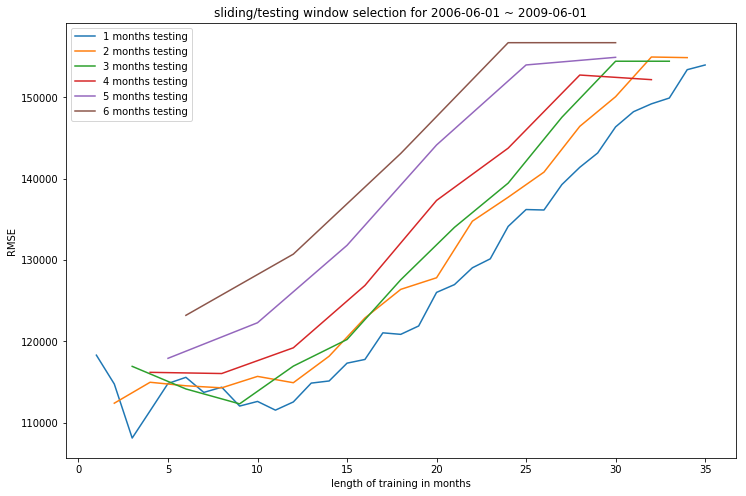

In [20]:
fig=plt.figure(figsize=(12,8))
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months testing'.format(j))

plt.title('sliding/testing window selection for 2006-06-01 ~ 2009-06-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [17]:
### redo for 2009~2011
df_track2 = pp.dataset(feature='delivered', valid=True, date=('2009-01-01', '2012-01-01'))
print(df_track2.shape)

# total dataset is 5 years = 60 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track2.shape[0]
total_months = 48
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track2[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon
[dp] track/sliding/test window size: 4100, 2050, 2050
[dp] train/valid/test size: 2050, 2050, 2050
[dp] validation step is skipped


(98436, 15)
use 1 months training, 1 months testing, total dataset length:6150


[dp] track/sliding/test window size: 6150, 4100, 2050
[dp] train/valid/test size: 4100, 2050, 2050
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:8200


[dp] track/sliding/test window size: 8200, 6150, 2050
[dp] train/valid/test size: 6150, 2050, 2050
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:10250


[dp] track/sliding/test window size: 10250, 8200, 2050
[dp] train/valid/test size: 8200, 2050, 2050
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:12300


[dp] track/sliding/test window size: 12300, 10250, 2050
[dp] train/valid/test size: 10250, 2050, 2050
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:14350


[dp] track/sliding/test window size: 14350, 12300, 2050
[dp] train/valid/test size: 12300, 2050, 2050
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:16400


[dp] track/sliding/test window size: 16400, 14350, 2050
[dp] train/valid/test size: 14350, 2050, 2050
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:18450


[dp] track/sliding/test window size: 18450, 16400, 2050
[dp] train/valid/test size: 16400, 2050, 2050
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:20500


[dp] track/sliding/test window size: 20500, 18450, 2050
[dp] train/valid/test size: 18450, 2050, 2050
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:22550


[dp] track/sliding/test window size: 22550, 20500, 2050
[dp] train/valid/test size: 20500, 2050, 2050
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:24600


[dp] track/sliding/test window size: 24600, 22550, 2050
[dp] train/valid/test size: 22550, 2050, 2050
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:26650


[dp] track/sliding/test window size: 26650, 24600, 2050
[dp] train/valid/test size: 24600, 2050, 2050
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:28700


[dp] track/sliding/test window size: 28700, 26650, 2050
[dp] train/valid/test size: 26650, 2050, 2050
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:30750


[dp] track/sliding/test window size: 30750, 28700, 2050
[dp] train/valid/test size: 28700, 2050, 2050
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:32800


[dp] track/sliding/test window size: 32800, 30750, 2050
[dp] train/valid/test size: 30750, 2050, 2050
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:34850


[dp] track/sliding/test window size: 34850, 32800, 2050
[dp] train/valid/test size: 32800, 2050, 2050
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:36900


[dp] track/sliding/test window size: 36900, 34850, 2050
[dp] train/valid/test size: 34850, 2050, 2050
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:38950


[dp] track/sliding/test window size: 38950, 36900, 2050
[dp] train/valid/test size: 36900, 2050, 2050
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:41000


[dp] track/sliding/test window size: 41000, 38950, 2050
[dp] train/valid/test size: 38950, 2050, 2050
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:43050


[dp] track/sliding/test window size: 43050, 41000, 2050
[dp] train/valid/test size: 41000, 2050, 2050
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:45100


[dp] track/sliding/test window size: 45100, 43050, 2050
[dp] train/valid/test size: 43050, 2050, 2050
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:47150


[dp] track/sliding/test window size: 47150, 45100, 2050
[dp] train/valid/test size: 45100, 2050, 2050
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:49200


[dp] track/sliding/test window size: 49200, 47150, 2050
[dp] train/valid/test size: 47150, 2050, 2050
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:51250


[dp] track/sliding/test window size: 51250, 49200, 2050
[dp] train/valid/test size: 49200, 2050, 2050
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:53300


[dp] track/sliding/test window size: 53300, 51250, 2050
[dp] train/valid/test size: 51250, 2050, 2050
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:55350


[dp] track/sliding/test window size: 55350, 53300, 2050
[dp] train/valid/test size: 53300, 2050, 2050
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:57400


[dp] track/sliding/test window size: 57400, 55350, 2050
[dp] train/valid/test size: 55350, 2050, 2050
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:59450


[dp] track/sliding/test window size: 59450, 57400, 2050
[dp] train/valid/test size: 57400, 2050, 2050
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:61500


[dp] track/sliding/test window size: 61500, 59450, 2050
[dp] train/valid/test size: 59450, 2050, 2050
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:63550


[dp] track/sliding/test window size: 63550, 61500, 2050
[dp] train/valid/test size: 61500, 2050, 2050
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:65600


[dp] track/sliding/test window size: 65600, 63550, 2050
[dp] train/valid/test size: 63550, 2050, 2050
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:67650


[dp] track/sliding/test window size: 67650, 65600, 2050
[dp] train/valid/test size: 65600, 2050, 2050
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:69700


[dp] track/sliding/test window size: 69700, 67650, 2050
[dp] train/valid/test size: 67650, 2050, 2050
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:71750


[dp] track/sliding/test window size: 71750, 69700, 2050
[dp] train/valid/test size: 69700, 2050, 2050
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:73800


[dp] track/sliding/test window size: 73800, 71750, 2050
[dp] train/valid/test size: 71750, 2050, 2050
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:75850


[dp] track/sliding/test window size: 75850, 73800, 2050
[dp] train/valid/test size: 73800, 2050, 2050
[dp] validation step is skipped


use 36 months training, 1 months testing, total dataset length:77900


[dp] track/sliding/test window size: 77900, 75850, 2050
[dp] train/valid/test size: 75850, 2050, 2050
[dp] validation step is skipped


use 37 months training, 1 months testing, total dataset length:79950


[dp] track/sliding/test window size: 79950, 77900, 2050
[dp] train/valid/test size: 77900, 2050, 2050
[dp] validation step is skipped


use 38 months training, 1 months testing, total dataset length:82000


[dp] track/sliding/test window size: 82000, 79950, 2050
[dp] train/valid/test size: 79950, 2050, 2050
[dp] validation step is skipped


use 39 months training, 1 months testing, total dataset length:84050


[dp] track/sliding/test window size: 84050, 82000, 2050
[dp] train/valid/test size: 82000, 2050, 2050
[dp] validation step is skipped


use 40 months training, 1 months testing, total dataset length:86100


[dp] track/sliding/test window size: 86100, 84050, 2050
[dp] train/valid/test size: 84050, 2050, 2050
[dp] validation step is skipped


use 41 months training, 1 months testing, total dataset length:88150


[dp] track/sliding/test window size: 88150, 86100, 2050
[dp] train/valid/test size: 86100, 2050, 2050
[dp] validation step is skipped


use 42 months training, 1 months testing, total dataset length:90200


[dp] track/sliding/test window size: 90200, 88150, 2050
[dp] train/valid/test size: 88150, 2050, 2050
[dp] validation step is skipped


use 43 months training, 1 months testing, total dataset length:92250


[dp] track/sliding/test window size: 92250, 90200, 2050
[dp] train/valid/test size: 90200, 2050, 2050
[dp] validation step is skipped


use 44 months training, 1 months testing, total dataset length:94300


[dp] track/sliding/test window size: 94300, 92250, 2050
[dp] train/valid/test size: 92250, 2050, 2050
[dp] validation step is skipped


use 45 months training, 1 months testing, total dataset length:96350


[dp] track/sliding/test window size: 96350, 94300, 2050
[dp] train/valid/test size: 94300, 2050, 2050
[dp] validation step is skipped


use 46 months training, 1 months testing, total dataset length:98400


[dp] track/sliding/test window size: 96386, 94336, 2050
[dp] train/valid/test size: 94336, 2050, 2050
[dp] validation step is skipped


use 47 months training, 1 months testing, total dataset length:98436


[dp] track/sliding/test window size: 8202, 4101, 4101
[dp] train/valid/test size: 4101, 4101, 4101
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:12303


[dp] track/sliding/test window size: 12303, 8202, 4101
[dp] train/valid/test size: 8202, 4101, 4101
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:16404


[dp] track/sliding/test window size: 16404, 12303, 4101
[dp] train/valid/test size: 12303, 4101, 4101
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:20505


[dp] track/sliding/test window size: 20505, 16404, 4101
[dp] train/valid/test size: 16404, 4101, 4101
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:24606


[dp] track/sliding/test window size: 24606, 20505, 4101
[dp] train/valid/test size: 20505, 4101, 4101
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:28707


[dp] track/sliding/test window size: 28707, 24606, 4101
[dp] train/valid/test size: 24606, 4101, 4101
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:32808


[dp] track/sliding/test window size: 32808, 28707, 4101
[dp] train/valid/test size: 28707, 4101, 4101
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:36909


[dp] track/sliding/test window size: 36909, 32808, 4101
[dp] train/valid/test size: 32808, 4101, 4101
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:41010


[dp] track/sliding/test window size: 41010, 36909, 4101
[dp] train/valid/test size: 36909, 4101, 4101
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:45111


[dp] track/sliding/test window size: 45111, 41010, 4101
[dp] train/valid/test size: 41010, 4101, 4101
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:49212


[dp] track/sliding/test window size: 49212, 45111, 4101
[dp] train/valid/test size: 45111, 4101, 4101
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:53313


[dp] track/sliding/test window size: 53313, 49212, 4101
[dp] train/valid/test size: 49212, 4101, 4101
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:57414


[dp] track/sliding/test window size: 57414, 53313, 4101
[dp] train/valid/test size: 53313, 4101, 4101
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:61515


[dp] track/sliding/test window size: 61515, 57414, 4101
[dp] train/valid/test size: 57414, 4101, 4101
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:65616


[dp] track/sliding/test window size: 65616, 61515, 4101
[dp] train/valid/test size: 61515, 4101, 4101
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:69717


[dp] track/sliding/test window size: 69717, 65616, 4101
[dp] train/valid/test size: 65616, 4101, 4101
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:73818


[dp] track/sliding/test window size: 73818, 69717, 4101
[dp] train/valid/test size: 69717, 4101, 4101
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:77919


[dp] track/sliding/test window size: 77919, 73818, 4101
[dp] train/valid/test size: 73818, 4101, 4101
[dp] validation step is skipped


use 36 months training, 2 months testing, total dataset length:82020


[dp] track/sliding/test window size: 82020, 77919, 4101
[dp] train/valid/test size: 77919, 4101, 4101
[dp] validation step is skipped


use 38 months training, 2 months testing, total dataset length:86121


[dp] track/sliding/test window size: 86121, 82020, 4101
[dp] train/valid/test size: 82020, 4101, 4101
[dp] validation step is skipped


use 40 months training, 2 months testing, total dataset length:90222


[dp] track/sliding/test window size: 90222, 86121, 4101
[dp] train/valid/test size: 86121, 4101, 4101
[dp] validation step is skipped


use 42 months training, 2 months testing, total dataset length:94323


[dp] track/sliding/test window size: 94323, 90222, 4101
[dp] train/valid/test size: 90222, 4101, 4101
[dp] validation step is skipped


use 44 months training, 2 months testing, total dataset length:98424


[dp] track/sliding/test window size: 94335, 90234, 4101
[dp] train/valid/test size: 90234, 4101, 4101
[dp] validation step is skipped


use 46 months training, 2 months testing, total dataset length:98436


[dp] track/sliding/test window size: 12304, 6152, 6152
[dp] train/valid/test size: 6152, 6152, 6152
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:18456


[dp] track/sliding/test window size: 18456, 12304, 6152
[dp] train/valid/test size: 12304, 6152, 6152
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:24608


[dp] track/sliding/test window size: 24608, 18456, 6152
[dp] train/valid/test size: 18456, 6152, 6152
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:30760


[dp] track/sliding/test window size: 30760, 24608, 6152
[dp] train/valid/test size: 24608, 6152, 6152
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:36912


[dp] track/sliding/test window size: 36912, 30760, 6152
[dp] train/valid/test size: 30760, 6152, 6152
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:43064


[dp] track/sliding/test window size: 43064, 36912, 6152
[dp] train/valid/test size: 36912, 6152, 6152
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:49216


[dp] track/sliding/test window size: 49216, 43064, 6152
[dp] train/valid/test size: 43064, 6152, 6152
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:55368


[dp] track/sliding/test window size: 55368, 49216, 6152
[dp] train/valid/test size: 49216, 6152, 6152
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:61520


[dp] track/sliding/test window size: 61520, 55368, 6152
[dp] train/valid/test size: 55368, 6152, 6152
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:67672


[dp] track/sliding/test window size: 67672, 61520, 6152
[dp] train/valid/test size: 61520, 6152, 6152
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:73824


[dp] track/sliding/test window size: 73824, 67672, 6152
[dp] train/valid/test size: 67672, 6152, 6152
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:79976


[dp] track/sliding/test window size: 79976, 73824, 6152
[dp] train/valid/test size: 73824, 6152, 6152
[dp] validation step is skipped


use 36 months training, 3 months testing, total dataset length:86128


[dp] track/sliding/test window size: 86128, 79976, 6152
[dp] train/valid/test size: 79976, 6152, 6152
[dp] validation step is skipped


use 39 months training, 3 months testing, total dataset length:92280


[dp] track/sliding/test window size: 92280, 86128, 6152
[dp] train/valid/test size: 86128, 6152, 6152
[dp] validation step is skipped


use 42 months training, 3 months testing, total dataset length:98432


[dp] track/sliding/test window size: 92284, 86132, 6152
[dp] train/valid/test size: 86132, 6152, 6152
[dp] validation step is skipped


use 45 months training, 3 months testing, total dataset length:98436


[dp] track/sliding/test window size: 16406, 8203, 8203
[dp] train/valid/test size: 8203, 8203, 8203
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:24609


[dp] track/sliding/test window size: 24609, 16406, 8203
[dp] train/valid/test size: 16406, 8203, 8203
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:32812


[dp] track/sliding/test window size: 32812, 24609, 8203
[dp] train/valid/test size: 24609, 8203, 8203
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:41015


[dp] track/sliding/test window size: 41015, 32812, 8203
[dp] train/valid/test size: 32812, 8203, 8203
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:49218


[dp] track/sliding/test window size: 49218, 41015, 8203
[dp] train/valid/test size: 41015, 8203, 8203
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:57421


[dp] track/sliding/test window size: 57421, 49218, 8203
[dp] train/valid/test size: 49218, 8203, 8203
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:65624


[dp] track/sliding/test window size: 65624, 57421, 8203
[dp] train/valid/test size: 57421, 8203, 8203
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:73827


[dp] track/sliding/test window size: 73827, 65624, 8203
[dp] train/valid/test size: 65624, 8203, 8203
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:82030


[dp] track/sliding/test window size: 82030, 73827, 8203
[dp] train/valid/test size: 73827, 8203, 8203
[dp] validation step is skipped


use 36 months training, 4 months testing, total dataset length:90233


[dp] track/sliding/test window size: 90233, 82030, 8203
[dp] train/valid/test size: 82030, 8203, 8203
[dp] validation step is skipped


use 40 months training, 4 months testing, total dataset length:98436


[dp] track/sliding/test window size: 90233, 82030, 8203
[dp] train/valid/test size: 82030, 8203, 8203
[dp] validation step is skipped


use 44 months training, 4 months testing, total dataset length:98436


[dp] track/sliding/test window size: 21874, 10937, 10937
[dp] train/valid/test size: 10937, 10937, 10937
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:32811


[dp] track/sliding/test window size: 32811, 21874, 10937
[dp] train/valid/test size: 21874, 10937, 10937
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:43748


[dp] track/sliding/test window size: 43748, 32811, 10937
[dp] train/valid/test size: 32811, 10937, 10937
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:54685


[dp] track/sliding/test window size: 54685, 43748, 10937
[dp] train/valid/test size: 43748, 10937, 10937
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:65622


[dp] track/sliding/test window size: 65622, 54685, 10937
[dp] train/valid/test size: 54685, 10937, 10937
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:76559


[dp] track/sliding/test window size: 76559, 65622, 10937
[dp] train/valid/test size: 65622, 10937, 10937
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:87496


[dp] track/sliding/test window size: 87496, 76559, 10937
[dp] train/valid/test size: 76559, 10937, 10937
[dp] validation step is skipped


use 35 months training, 5 months testing, total dataset length:98433


[dp] track/sliding/test window size: 87499, 76562, 10937
[dp] train/valid/test size: 76562, 10937, 10937
[dp] validation step is skipped


use 40 months training, 5 months testing, total dataset length:98436


[dp] track/sliding/test window size: 24608, 12304, 12304
[dp] train/valid/test size: 12304, 12304, 12304
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:36912


[dp] track/sliding/test window size: 36912, 24608, 12304
[dp] train/valid/test size: 24608, 12304, 12304
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:49216


[dp] track/sliding/test window size: 49216, 36912, 12304
[dp] train/valid/test size: 36912, 12304, 12304
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:61520


[dp] track/sliding/test window size: 61520, 49216, 12304
[dp] train/valid/test size: 49216, 12304, 12304
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:73824


[dp] track/sliding/test window size: 73824, 61520, 12304
[dp] train/valid/test size: 61520, 12304, 12304
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:86128


[dp] track/sliding/test window size: 86128, 73824, 12304
[dp] train/valid/test size: 73824, 12304, 12304
[dp] validation step is skipped


use 36 months training, 6 months testing, total dataset length:98432


[dp] track/sliding/test window size: 86132, 73828, 12304
[dp] train/valid/test size: 73828, 12304, 12304
[dp] validation step is skipped


use 42 months training, 6 months testing, total dataset length:98436


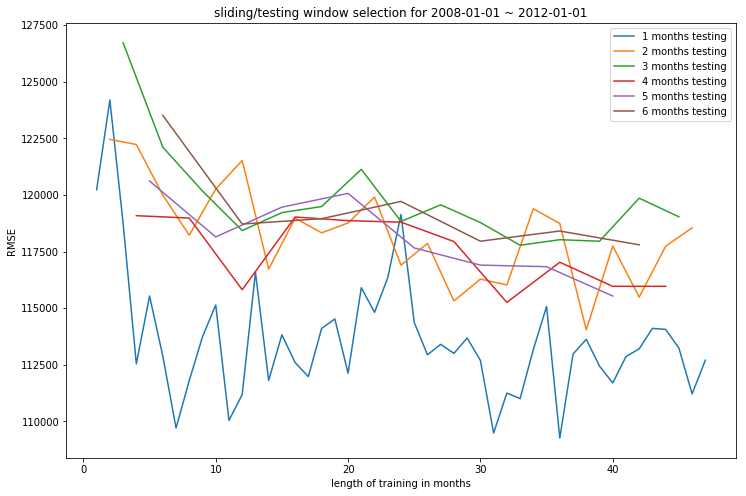

In [18]:
fig=plt.figure(figsize=(12,8))
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months testing'.format(j))

plt.title('sliding/testing window selection for 2008-01-01 ~ 2012-01-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()